In [ ]:
# !pip install torchsummary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

%matplotlib inline

In [ ]:
mean, std = (0.5,), (0.5,)
batch_size = 128

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

transform_train = transforms.Compose([transforms.RandomRotation((-20, 20)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1,
                                          worker_init_fn=seed_worker)


transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(mean, std)])

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1,
                                         worker_init_fn=seed_worker)

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(img.transpose((1, 2, 0)))
    plt.show()

In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

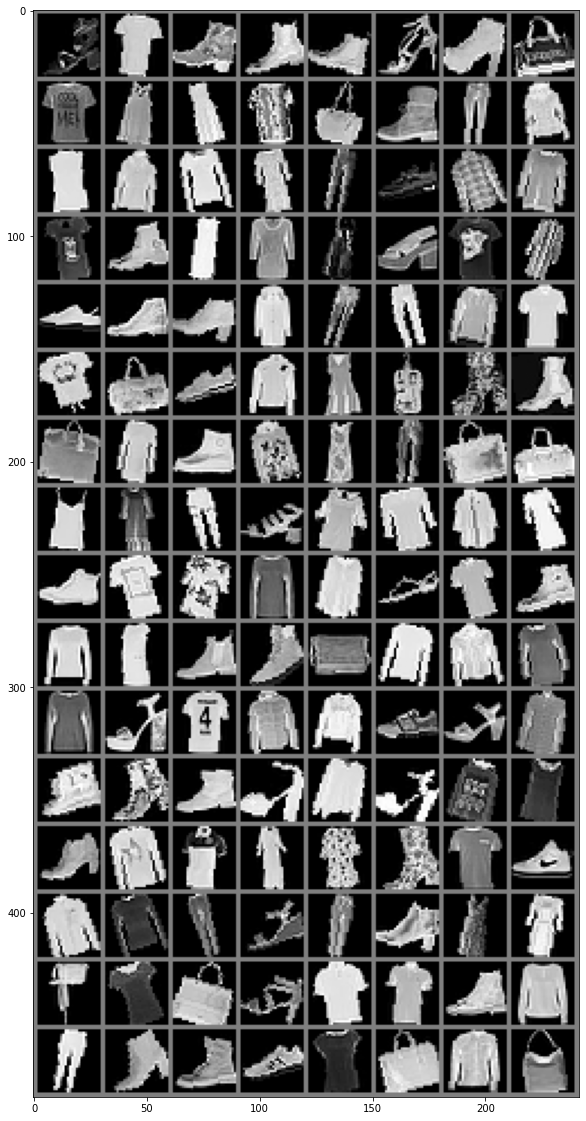

tensor(5) tensor(5) tensor(3) tensor(3) tensor(3) tensor(5) tensor(3) tensor(0) tensor(5) tensor(9) tensor(9) tensor(9) tensor(0) tensor(3) tensor(0) tensor(9) tensor(5) tensor(9) tensor(9) tensor(9) tensor(0) tensor(8) tensor(9) tensor(9) tensor(5) tensor(3) tensor(9) tensor(5) tensor(9) tensor(5) tensor(5) tensor(9) tensor(8) tensor(3) tensor(3) tensor(9) tensor(0) tensor(0) tensor(9) tensor(5) tensor(5) tensor(0) tensor(8) tensor(9) tensor(9) tensor(0) tensor(3) tensor(3) tensor(0) tensor(9) tensor(3) tensor(9) tensor(9) tensor(0) tensor(0) tensor(0) tensor(5) tensor(9) tensor(0) tensor(5) tensor(9) tensor(5) tensor(9) tensor(9) tensor(3) tensor(5) tensor(9) tensor(9) tensor(9) tensor(5) tensor(5) tensor(3) tensor(9) tensor(9) tensor(3) tensor(3) tensor(0) tensor(9) tensor(9) tensor(9) tensor(9) tensor(5) tensor(5) tensor(9) tensor(9) tensor(8) tensor(5) tensor(9) tensor(3) tensor(3) tensor(3) tensor(5) tensor(9) tensor(5) tensor(9) tensor(9) tensor(3) tensor(9) tensor(5) tensor(9) 

In [ ]:
# show images
plt.figure(figsize=(20,20))
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[labels[j]] for j in range(batch_size)))

In [ ]:
class Trainer(object):

    def __init__(self, model, optimizer, criterion, 
                 train_loader, test_loader, seed=0):
        Trainer.set_seed(seed)
        
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.metrics = {
            'Train Loss': [],
            'Test Loss': [],
            'Test Accuracy': []
        }


    def train_step(self):
        train_loss = 0
        self.model.train()

        for images, labels in tqdm(self.train_loader):
            images, labels = images.to(device), labels.to(device)
            self.optimizer.zero_grad()

            log_ps = self.model(images)
            loss = self.criterion(log_ps, labels)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()

        mean_train_loss = train_loss/len(self.train_loader)
        self.metrics['Train Loss'].append(mean_train_loss)

        # return mean_train_loss


    def eval_step(self):
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            self.model.eval()
            for images, labels in self.test_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = self.model(images)
                test_loss += self.criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        mean_test_loss = test_loss/len(self.test_loader)
        self.metrics['Test Loss'].append(mean_test_loss)

        mean_accuracy = accuracy/len(self.test_loader)
        self.metrics['Test Accuracy'].append(mean_accuracy)

        # return mean_test_loss, mean_accuracy


    def summary(self, input_size=(1, 28, 28)):
        summary(self.model, input_size=input_size)


    def fit(self, epochs=10):
        print('Training is started...')

        for epoch in range(epochs):
            self.train_step()
            self.eval_step()

            print(f"Epoch: {epoch+1}/{epochs}", end=' ')
            for metric, values in self.metrics.items():
                print(f' | {metric}: {values[-1]:.3f}', end=' ')

            print()
        
        print('Finished training')

        return self.metrics


    @staticmethod
    def set_seed(seed=0):

        torch.manual_seed(0)
        np.random.seed(0)
        random.seed(0)

        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(999)

## Teacher

In [ ]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3) # same padding
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # same padding
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # in_channels=32 (=out_channels of conv1), out_channels=32, kernel_size=3
        
        self.linear1 = nn.Linear(in_features=256*7*7, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=10)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.avgpool(x)

        x = x.view(-1, 256*7*7) # flatten
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        
        return x


teacher = Teacher()
teacher_criterion = nn.NLLLoss()
teacher_optimizer = optim.Adam(teacher.parameters(), betas=(0.94, 0.999), weight_decay=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device:
    print('Thanks google')
    teacher.to(device)

cuda
Thanks google


In [ ]:
teacher_object = Trainer(model=teacher, 
                         optimizer=teacher_optimizer,
                         criterion=teacher_criterion, 
                         train_loader=trainloader,
                         test_loader=testloader)
teacher_object.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           3,200
            Conv2d-2          [-1, 128, 28, 28]          73,856
         MaxPool2d-3          [-1, 128, 14, 14]               0
            Conv2d-4          [-1, 256, 14, 14]         295,168
         AvgPool2d-5            [-1, 256, 7, 7]               0
            Linear-6                  [-1, 128]       1,605,760
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 1,979,274
Trainable params: 1,979,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.82
Params size (MB): 7.55
Estimated Total Size (MB): 9.37
----------------------------------------------------------------


In [ ]:
teacher_metrics = teacher_object.fit(epochs=6)
train_losses, test_losses = teacher_metrics['Train Loss'], teacher_metrics['Test Loss']

Training is started...



Epoch: 1/6  | Train Loss: 0.545  | Test Loss: 0.372  | Test Accuracy: 0.867 



Epoch: 2/6  | Train Loss: 0.360  | Test Loss: 0.316  | Test Accuracy: 0.887 



Epoch: 3/6  | Train Loss: 0.319  | Test Loss: 0.294  | Test Accuracy: 0.894 



Epoch: 4/6  | Train Loss: 0.290  | Test Loss: 0.285  | Test Accuracy: 0.899 



Epoch: 5/6  | Train Loss: 0.274  | Test Loss: 0.281  | Test Accuracy: 0.899 



Epoch: 6/6  | Train Loss: 0.263  | Test Loss: 0.287  | Test Accuracy: 0.895 
Finished training


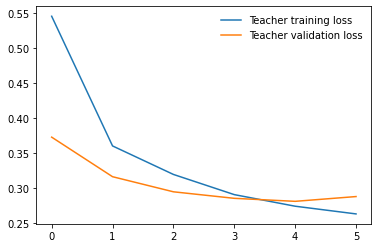

In [ ]:
plt.plot(train_losses, label='Teacher training loss')
plt.plot(test_losses, label='Teacher validation loss')
plt.legend(frameon=False)

plt.show()

## Student

In [ ]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=7, stride=1, padding=3) # same padding
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1) # same padding
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  # in_channels=32 (=out_channels of conv1), out_channels=32, kernel_size=3
        
        self.linear1 = nn.Linear(in_features=32*7*7, out_features=80)
        self.linear2 = nn.Linear(in_features=80, out_features=10)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.avgpool(x)

        x = x.view(-1, 32*7*7) # flatten
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        
        return x


student_base = Student()

In [ ]:
# Deep copy of 'student'
student_scratch = Student()
student_scratch.load_state_dict(student_base.state_dict())

student_scratch_criterion = nn.NLLLoss()
student_scratch_optimizer = optim.Adam(student_scratch.parameters(), betas=(0.94, 0.999), weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device:
    print('Thanks google')
    student_scratch.to(device)

cuda
Thanks google


In [ ]:
student_object = Trainer(model=student_scratch, 
                         optimizer=student_scratch_optimizer,
                         criterion=student_scratch_criterion, 
                         train_loader=trainloader,
                         test_loader=testloader)
student_object.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             400
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
         AvgPool2d-5             [-1, 32, 7, 7]               0
            Linear-6                   [-1, 80]         125,520
           Dropout-7                   [-1, 80]               0
            Linear-8                   [-1, 10]             810
Total params: 132,538
Trainable params: 132,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.51
Estimated Total Size (MB): 0.74
----------------------------------------------------------------


In [ ]:
student_metrics = student_object.fit(epochs=6)
train_losses, test_losses = student_metrics['Train Loss'], student_metrics['Test Loss']

Training is started...



Epoch: 1/6  | Train Loss: 0.716  | Test Loss: 0.521  | Test Accuracy: 0.806 



Epoch: 2/6  | Train Loss: 0.506  | Test Loss: 0.444  | Test Accuracy: 0.838 



Epoch: 3/6  | Train Loss: 0.446  | Test Loss: 0.406  | Test Accuracy: 0.857 



Epoch: 4/6  | Train Loss: 0.405  | Test Loss: 0.381  | Test Accuracy: 0.865 



Epoch: 5/6  | Train Loss: 0.378  | Test Loss: 0.362  | Test Accuracy: 0.869 



Epoch: 6/6  | Train Loss: 0.358  | Test Loss: 0.369  | Test Accuracy: 0.868 
Finished training


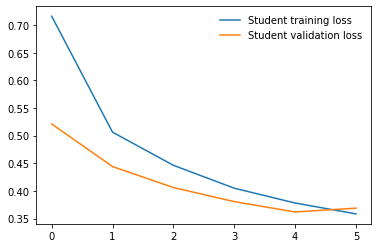

In [ ]:
plt.plot(train_losses, label='Student training loss')
plt.plot(test_losses, label='Student validation loss')
plt.legend(frameon=False)

plt.show()

## Distiller

In [ ]:
class DistillerTrainer(Trainer):

    def __init__(self, 
                 teacher_model, student_model, 
                 optimizer, 
                 student_criterion, 
                 distillation_criterion,
                 train_loader, test_loader,
                 alpha=0.4, temperature=2):
        
        super().__init__(model=student_model, 
                         optimizer=optimizer,
                         criterion=student_criterion,
                         train_loader=train_loader,
                         test_loader=test_loader)
        
        self.teacher_model = teacher_model.eval()
        self.distillation_criterion = distillation_criterion
        self.temperature = temperature
        self.alpha = alpha
        self.metrics.update({'Distillation Loss': []})


    def train_step(self):
        train_loss = 0
        mean_distillation_loss = 0
        self.model.train()

        for images, labels in tqdm(self.train_loader):
            images, labels = images.to(device), labels.to(device)
            self.optimizer.zero_grad()

            teacher_log_ps = self.teacher_model(images)

            student_log_ps = self.model(images)
            student_loss = self.criterion(student_log_ps, labels)

            distillation_loss = self.distillation_criterion(
                teacher_log_ps / self.temperature,
                student_log_ps / self.temperature,
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
            loss.backward()
            self.optimizer.step()

            train_loss += student_loss.item()
            mean_distillation_loss += distillation_loss.item()

        mean_train_loss = train_loss/len(self.train_loader)
        mean_distillation_loss = mean_distillation_loss/len(self.train_loader)

        self.metrics['Train Loss'].append(mean_train_loss)
        self.metrics['Distillation Loss'].append(mean_distillation_loss)

In [ ]:
student_distil = Student()
student_distil.load_state_dict(student_base.state_dict())
student_criterion = nn.NLLLoss()
distillation_criterion = nn.KLDivLoss(log_target=True)
student_optimizer = optim.Adam(student_distil.parameters(), betas=(0.94, 0.999), weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device:
    print('Thanks google')
    student_distil.to(device)

cuda
Thanks google


In [ ]:
distiller_object = DistillerTrainer(teacher_model=teacher,
                                    student_model=student_distil,
                                    optimizer=student_optimizer,
                                    student_criterion=student_criterion,
                                    distillation_criterion=distillation_criterion, 
                                    train_loader=trainloader,
                                    test_loader=testloader)
distiller_object.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             400
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
         AvgPool2d-5             [-1, 32, 7, 7]               0
            Linear-6                   [-1, 80]         125,520
           Dropout-7                   [-1, 80]               0
            Linear-8                   [-1, 10]             810
Total params: 132,538
Trainable params: 132,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.51
Estimated Total Size (MB): 0.74
----------------------------------------------------------------


In [ ]:
distiller_metrics = distiller_object.fit(epochs=6)
train_losses, test_losses = distiller_metrics['Train Loss'], distiller_metrics['Test Loss']

Training is started...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."



Epoch: 1/6  | Train Loss: 0.751  | Test Loss: 0.549  | Test Accuracy: 0.799  | Distillation Loss: 0.137 



Epoch: 2/6  | Train Loss: 0.531  | Test Loss: 0.475  | Test Accuracy: 0.830  | Distillation Loss: 0.052 



Epoch: 3/6  | Train Loss: 0.473  | Test Loss: 0.436  | Test Accuracy: 0.844  | Distillation Loss: 0.039 



Epoch: 4/6  | Train Loss: 0.426  | Test Loss: 0.419  | Test Accuracy: 0.856  | Distillation Loss: 0.029 



Epoch: 5/6  | Train Loss: 0.397  | Test Loss: 0.381  | Test Accuracy: 0.870  | Distillation Loss: 0.023 



Epoch: 6/6  | Train Loss: 0.371  | Test Loss: 0.396  | Test Accuracy: 0.867  | Distillation Loss: 0.019 
Finished training


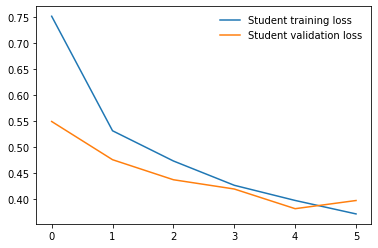

In [ ]:
plt.plot(train_losses, label='Student training loss')
plt.plot(test_losses, label='Student validation loss')
plt.legend(frameon=False)

plt.show()